# interpolate time dependent llc variable along trajectories

Right now there are lots of gaps as a diagnostic computed on one tile

Zoé to do (maybe):

- rechunk such as it looks more like snapshots
- add other variables (sea level, sst, sss, wind)


In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

import pyinterp
import pyinterp.backends.xarray

import mitequinox.plot as pl
import mitequinox.utils as ut
#import mitequinox.parcels as pa

In [2]:
if False:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(processes=4, cores=4)
    #w = cluster.scale(jobs=15) # heavier data processing
    w = cluster.scale(jobs=10)
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster(n_workers=2, threads_per_worker=1)
    client = Client(cluster)
    client

In [4]:
#print(cluster.job_script())

---

## load data

In [8]:
site = "california"

site_dir = os.path.join(ut.diag_dir, "regional_"+site)

#ds = xr.open_zarr(os.path.join(site_dir, "llc.zarr") )
df = dd.read_parquet(os.path.join(site_dir, "llc_parcels_time_mean"))

In [5]:
df = df.repartition(npartitions=500).persist()

In [6]:
df.mean().compute()

trajectory             3.735278e+07
lat                    3.298942e+01
lon                   -1.289479e+02
z                      0.000000e+00
zonal_velocity        -1.299742e-07
meridional_velocity   -4.245208e-07
sea_level              3.995290e-01
temperature            1.640501e+01
salinity               3.365490e+01
Eta_interp             3.889707e-01
SSU_interp            -1.626861e-02
SST_interp             1.646110e+01
SSV_interp            -4.589301e-02
SSS_interp             3.366238e+01
dtype: float64

---

## interpolate new diagnostic along drifter tracks

ds is not properly chunked at the moment

In [7]:
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,Eta_interp,SSU_interp,SST_interp,SSV_interp,SSS_interp
time,,,,,,,,,,,,,,
2011-11-15,38000612,43.223770,-152.822922,0.0,0.0,0.0,0.0,0.0,0.0,0.301963,0.111188,11.264963,-0.047701,32.847267
2011-11-15,38000637,43.223770,-151.781250,0.0,0.0,0.0,0.0,0.0,0.0,0.289056,0.094942,11.465209,0.017127,32.781781
2011-11-15,38000661,42.514122,-150.739578,0.0,0.0,0.0,0.0,0.0,0.0,0.323792,0.107724,12.161278,-0.024647,32.890323
2011-11-15,38000685,41.797028,-149.697922,0.0,0.0,0.0,0.0,0.0,0.0,0.352433,0.089004,13.222504,-0.016940,33.018796
2011-11-15,38000692,46.660358,-149.697922,0.0,0.0,0.0,0.0,0.0,0.0,0.242264,0.074070,8.888128,0.006434,32.550297


In [10]:
def interp(df):

    if hasattr(df, "time"):
        t = df["time"].unique()[0]
    elif df.index.name == "time":
        # dask dataframe
        t = df.index.unique()[0]
    elif hasattr(df, "name"):
        # when mapped after groupby
        t = df.name
    else:
        assert False, "Cannot find float id"

    diag = load_instantaneous_diagnostic(t)

    # interpolate on tracks
    for v in diag:
        df[v] = interp_snapshot(diag[v], df)

    return df
    

def load_instantaneous_diagnostic(t):
    
    # overwrite default with threaded scheduler    
    # "single-threaded"
    import dask
    
    with dask.config.set(scheduler="single-threaded"):

        # load data
        # not properly chunked
        #ds = xr.open_zarr(os.path.join(site_dir, "llc.zarr") )
        #ds = xr.open_zarr(os.path.join(ut.ref_data_dir, "SSU.zarr") ).rename({"i_g": "i"})
        #ds = ds.sel(face=10)
        #grd = (xr.open_zarr(os.path.join(ut.ref_data_dir, "grid.zarr") )[["XC", "YC"]]
        #       .sel(face=10)
        #       .rename({"XC": "lon", "YC": "lat"})
        #      )
        #ds = xr.merge([ds, grd])
        #ds = ds.sel(time=t, method="nearest")
        
        #diag_dir = '/home/datawork-lops-osi/equinox/mit4320/diags/'
        ds = xr.merge([(xr.open_zarr(os.path.join(ut.diag_dir,"dEta_"+_dir+"_california.zarr"))
                        .sel(time=t, method="nearest")
                        .rename({"dEta_"+_dir+"_california": "dEta_"+_dir})
                        .rename({"XC": "lon", "YC": "lat"})
                       )
                       for _dir in ["dx", "dy"]]
                     )
        
        # build diagnostic
        #diag = 0.5*(ds["meridional_velocity"]**2+ds["zonal_velocity"]**2)        
        #diag = ds["SSU"].compute()
        diag = ds.compute()
         
    return diag

def interp_snapshot(da, df):

    # prepare interpolator
    mesh = pyinterp.RTree()
    lons = da.lon
    lats = da.lat
    mesh.packing(
        np.vstack((lons.values.flatten(), lats.values.flatten())).T,
        da.values.flatten(),
    )

    # target positions
    lon = df["lon"].values
    lat = df["lat"].values

    out, neighbors = mesh.inverse_distance_weighting(
        np.vstack((lon, lat)).T,
        within=True,  # Extrapolation is forbidden
        radius=55000,  # In a radius of 5.5 Km
        k=8,  # We are looking for at most 8 neighbours
        num_threads=0,
    )
    
    return out

In [14]:
#_df = df.get_partition(0).compute().iloc[:1000, :]
#_df = df.get_partition(0)
_df = df

out = _df.groupby(_df.index).apply(interp).persist()

/dev/shm/pbs.5916147.datarmor0/ipykernel_10410/3337645608.py:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  out = _df.groupby(_df.index).apply(interp).persist()


In [15]:
out.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,Eta_interp,SSU_interp,SST_interp,SSV_interp,SSS_interp,dEta_dx,dEta_dy
time,,,,,,,,,,,,,,,,
2011-11-15 02:00:00,38000612,43.218834,-152.801402,0.0,3.049492e-06,-8.224012e-07,0.194598,11.341290,32.743732,0.301908,0.111860,11.275245,-0.046867,32.846305,NaN,NaN
2011-11-15 02:00:00,38000637,43.222802,-151.779637,0.0,1.146999e-07,-2.732827e-07,0.110377,11.187393,32.752048,0.289113,0.095251,11.465579,0.017118,32.782088,NaN,NaN
2011-11-15 02:00:00,38000661,42.512788,-150.719480,0.0,2.836833e-06,-1.399171e-07,0.086395,11.671886,32.792000,0.323762,0.107019,12.162857,-0.024284,32.890155,NaN,NaN
2011-11-15 02:00:00,38000685,41.795849,-149.693961,0.0,4.792952e-07,-1.159455e-07,0.076363,12.651238,33.008923,0.352460,0.089060,13.224021,-0.016837,33.018938,NaN,NaN
2011-11-15 02:00:00,38000692,46.658046,-149.698476,0.0,-1.298506e-07,-2.376438e-07,-0.008411,9.259451,32.548817,0.242278,0.074139,8.890303,0.006240,32.550432,NaN,NaN


In [16]:
from mitequinox.parcels import store_parquet

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5916147.datarmor0/parcels-55081/libparcels_random_1a1228a1-0e4f-4a1b-8f36-8e80a0419782.so


In [21]:
#store_parquet(site_dir, out, name="llc_parcels_time_mean_gradp", overwrite=True)
store_parquet(ut.diag_dir, out, name="california_parcels_time_mean_gradp", overwrite=True)

No reindexing
create new archive: /home/datawork-lops-osi/equinox/mit4320/diags/california_parcels_time_mean_gradp


'/home/datawork-lops-osi/equinox/mit4320/diags/california_parcels_time_mean_gradp'

--- 
## Reload and make a simple comparison

In [23]:
df = dd.read_parquet(os.path.join(ut.diag_dir, "california_parcels_time_mean_gradp"))
df = df.compute()
df = df.dropna()

In [16]:
ds = (xr.open_zarr(os.path.join(site_dir, "llc.zarr") )
      .sel(time="2012-03-01 00:00:00")
      .set_coords(["lon", "lat"])
     ).persist()
ds

<xarray.Dataset>
Dimensions:              (i: 636, j: 480)
Coordinates:
    Depth                (j, i) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    face                 int64 ...
  * i                    (i) int64 2765 2766 2767 2768 ... 3397 3398 3399 3400
  * j                    (j) int64 0 1 2 3 4 5 6 ... 473 474 475 476 477 478 479
    lat                  (j, i) float64 dask.array<chunksize=(128, 128), meta=np.ndarray>
    lon                  (j, i) float64 dask.array<chunksize=(128, 128), meta=np.ndarray>
    niter                int64 dask.array<chunksize=(), meta=np.ndarray>
    time                 datetime64[ns] 2012-03-01
Data variables:
    meridional_velocity  (j, i) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    zonal_velocity       (j, i) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>

(28.0, 41.0)

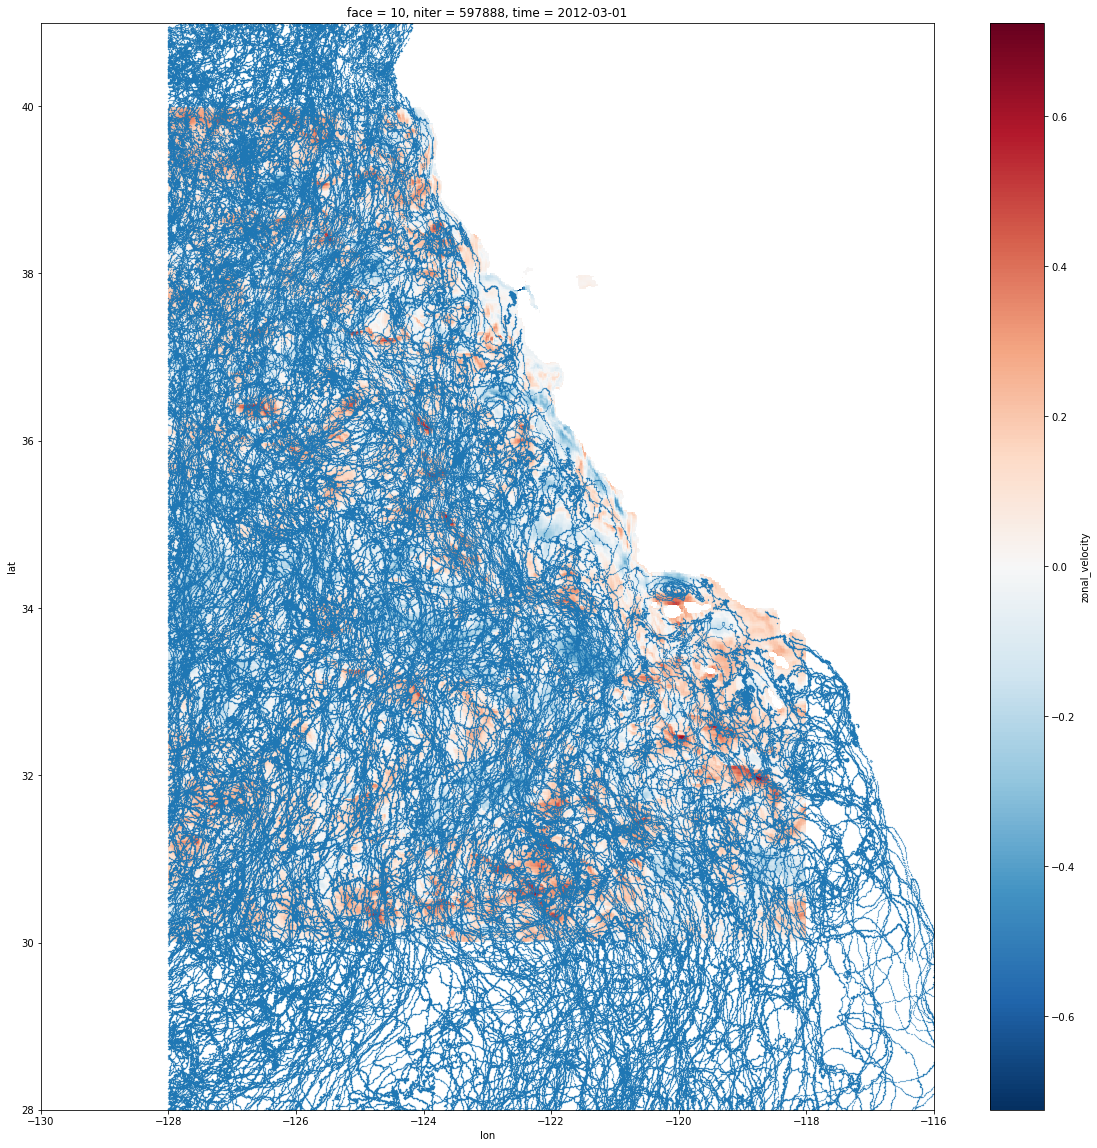

In [32]:
fig, ax = plt.subplots(1,1,figsize=(20,20))

ds["zonal_velocity"].plot(ax=ax, x="lon", y="lat")

ax.scatter(df["lon"], df["lat"], s=0.05)

ax.set_xlim(-130, -116)
ax.set_ylim(28, 41)

In [36]:
df

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,Eta_interp,SSU_interp,SST_interp,SSV_interp,SSS_interp,dEta_dx,dEta_dy
time,,,,,,,,,,,,,,,,
2011-11-15 02:00:00,38001179,41.783575,-127.830134,0.0,-1.084231e-06,-2.005433e-06,-0.946994,13.173021,32.818710,0.250434,-0.021667,12.448205,-0.071915,32.552241,-4.629283e-06,-0.000011
2011-11-15 02:00:00,38001180,42.515934,-127.835240,0.0,-1.990584e-06,3.290634e-07,-0.820190,13.054238,32.503811,0.266892,0.043187,12.336187,-0.111018,32.493393,2.459938e-06,0.000015
2011-11-15 02:00:00,38001181,43.215595,-127.809221,0.0,2.037402e-06,-9.198720e-07,-0.855425,12.895810,32.592831,0.252924,0.011754,12.243242,-0.060507,32.456283,-1.998817e-05,-0.000010
2011-11-15 02:00:00,38001182,43.922416,-127.825703,0.0,-5.823725e-07,-3.036064e-07,-0.915266,13.208350,32.336224,0.274240,0.005454,12.083866,-0.045065,32.395736,-2.482968e-05,-0.000006
2011-11-15 02:00:00,38001183,44.619940,-127.831165,0.0,-1.142888e-06,-2.835733e-07,-0.888931,12.961463,32.329632,0.268946,0.003329,12.081378,-0.069385,32.380809,-2.409666e-07,0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-31 02:00:00,37001779,19.750958,-124.763940,0.0,-1.206922e-06,6.979785e-07,1.044842,23.403948,34.778755,0.497988,-0.097912,21.707231,-0.029890,34.580080,5.062693e-06,-0.000006
2012-10-31 02:00:00,37001839,20.052768,-120.655927,0.0,-5.614431e-07,-1.092709e-07,1.059152,24.017523,34.730095,0.491421,-0.056752,22.130622,-0.011059,34.548992,6.633856e-06,-0.000032
2012-10-31 02:00:00,37001879,20.521469,-122.653700,0.0,-9.565615e-07,3.511301e-08,1.043831,23.298925,34.704357,0.500866,-0.086330,21.481799,-0.027827,34.518955,9.295957e-06,0.000010


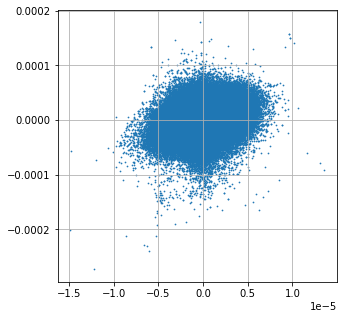

In [38]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.scatter( df["zonal_velocity"], -df["dEta_dy"], s=.5)
ax.grid()

---

## dev on one partition

In [52]:
_df = df.get_partition(20).compute()
t = _df.index[0]
_df.loc[t]

v = "zonal_velocity"

_da = (ds.set_coords(["lon", "lat"])[v]
       .sel(time=t)
       .compute()
      ) #, method="nearest"

In [53]:
_hdl.axes

<AxesSubplot:title={'center':'face = 10, niter = 766080, time = 2012-04-18T16...'}, xlabel='lon', ylabel='lat'>

<AxesSubplot:title={'center':'face = 10, niter = 382608, time = 2011-12-29T17...'}, xlabel='lon', ylabel='lat'>

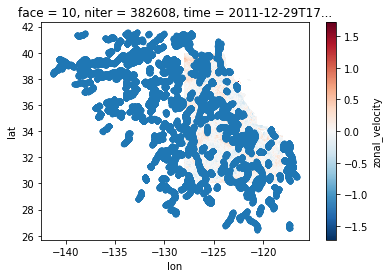

In [54]:
_hdl = _da.plot(x="lon", y="lat")

_df.plot.scatter(x="lon", y="lat", ax=_hdl.axes)

In [56]:
out = interp_snapshot(_da, _df)
np.nanmean(out)

In [38]:
cluster.close()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when 